## Pre-processing for Task

In [1]:
from monai import transforms as T
from glob import glob
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

image_files = sorted(glob(os.path.join('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/', "imagesTr", "*.nii.gz")))
label_files = sorted(glob(os.path.join('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/', "labelsTr", "*.nii.gz")))

In [2]:
default_preprocess = T.Compose(
                [
                    T.LoadImaged(keys=["image", "label"]),
                    T.EnsureChannelFirstd(keys=["image", "label"]),
                    T.Lambdad(keys="image", func=lambda x: x[:1]),
                    T.Orientationd(keys=["image", "label"], axcodes="RAS"),
                    T.Spacingd(
                        keys=["image", "label"],
                        pixdim=(0.5, 0.5, 1.2),
                        mode=("bilinear", "nearest"),
                    ),
                    T.NormalizeIntensityd(keys="image", channel_wise=True),
                    T.Resized(keys=["image", "label"], spatial_size=[512, 512, 20])
            ])

In [3]:
num_samples = 3
augment =  T.Compose(
                [
                    T.NormalizeIntensityd(
                        keys="image", nonzero=True, channel_wise=True
                    ),
                    T.RandCropByLabelClassesd(keys=["image", "label"], label_key = "label", spatial_size = [128, 128, 20],
                                              num_classes = 2, num_samples = num_samples, ratios = [0, 1]),
                    T.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
                    T.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
                    T.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
                ]
            )

In [4]:
transform=T.Compose([default_preprocess, augment])

In [5]:
data = [
            {"image": img, "label": lbl} for img, lbl in zip(image_files[:10], label_files[:10])
        ]



In [6]:
loader = T.LoadImaged(keys=["image", "label"])
loaded_data = [loader(d) for d in data]  
final_data = transform(data)

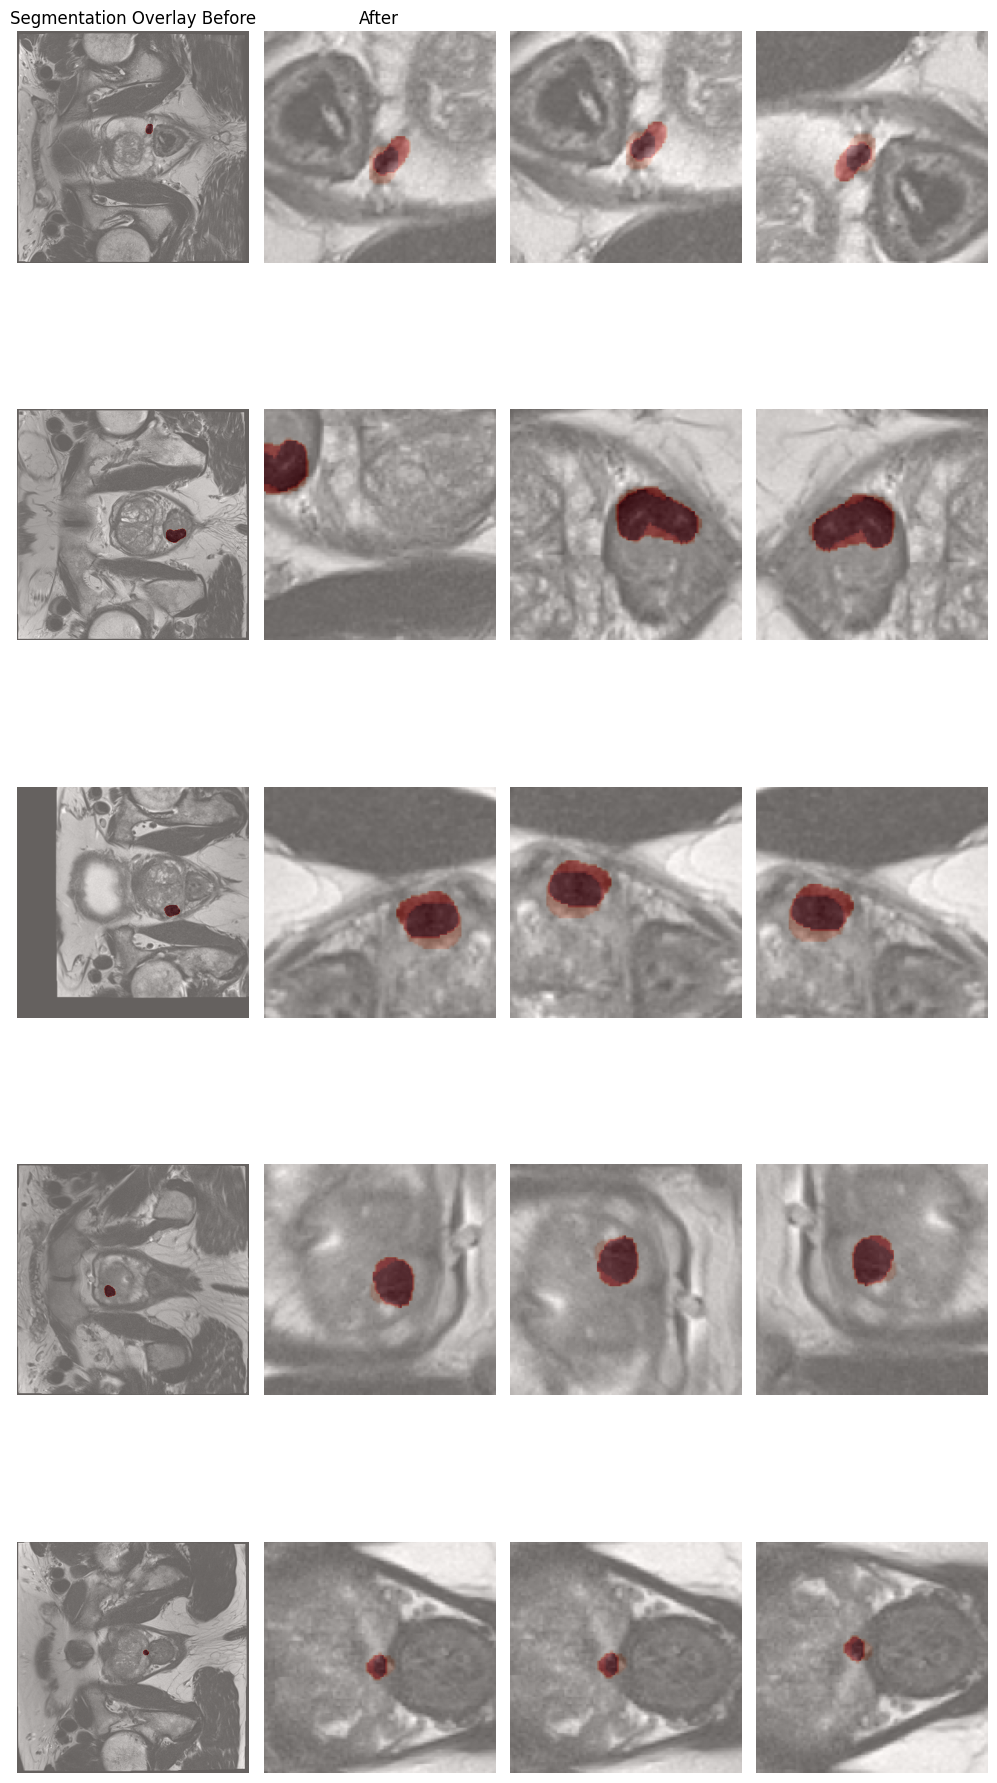

In [7]:
n = 5

fig, axes = plt.subplots(n, num_samples + 1, figsize=(10,20))

axes[0,0].set_title("Segmentation Overlay Before")
axes[0,1].set_title("After")

for i in range(n):
    
    sample = loaded_data[i]
    label_slices = np.sum(sample["label"], axis=(0, 1))  
    slice = np.argmax(label_slices)  

    axes[i, 0].imshow(sample['image'][:, :, slice, 0], cmap="gray")  
    axes[i, 0].imshow(sample["label"][:, :, slice], cmap="Reds", alpha=0.4)  
    axes[i, 0].axis("off")
    
    for j in range(num_samples):  # Loop over augmented versions
        
        label_slices_final = np.sum(final_data[i][j]["label"][0], axis=(0, 1))
        slice_final = np.argmax(label_slices_final)

        axes[i, j + 1].imshow(final_data[i][j]['image'][0, :, :, slice_final], cmap="gray")
        axes[i, j + 1].imshow(final_data[i][j]["label"][0, :, :, slice_final], cmap="Reds", alpha=0.4)
        axes[i, j + 1].axis("off")

    
plt.tight_layout()
plt.show()